In [1]:
import os
import dill

import numpy as np
from matplotlib import pyplot as plt

import TwoPUtils
import STX3KO_analyses as stx

from STX3KO_analyses import utilities_ES as u

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
def update_sess_dict(mouse, f, KO = True):
    scan_str = "%s_%03d_%03d" % (f['scene'],f['session'],f['scan'])

    source_folder = "Z:/giocomo/esay/Stx3/VRData"
    source_stem = os.path.join(source_folder, mouse, f['date'], f['scene'], scan_str)

    f['mouse']=mouse
    f.update({'vr_filename': os.path.join("Z:/giocomo/esay/Stx3/VRData",f['mouse'],f['date'],"%s_%d.sqlite" %(f['scene'],f['session'])),
              'scan_number': f['scan'],
              'prompt_for_keys': False,
              'VR_only': True,
              'scanner': "NLW",
             })
    return f

In [22]:
ko_sessions = stx.ymaze_sess_deets.KO_behavior_sessions
ctrl_sessions = stx.ymaze_sess_deets.CTRL_behavior_sessions
sparse_sessions = stx.ymaze_sess_deets.SparseKO_behavior_sessions

In [4]:
def run_and_save(fdict,comb_frames=0):

            
    sess = stx.session.YMazeSession(**fdict)
    sess.align_VR_to_2P()
    sess.get_trial_info()
    
    sess.add_timeseries(speed_raw=sess.vr_data['dz']._values)
    sess.add_pos_binned_trial_matrix('speed_raw')
    
    sess.add_timeseries(speed=sess.vr_data['dz']._values)
    sess.add_pos_binned_trial_matrix('speed')#, speed_thr=.01, speed = sess.timeseries['speed_raw'].ravel())

    err_lick, err = correct_lick_sensor_error(sess.vr_data['lick'],sess.trial_start_inds, sess.teleport_inds, correction_thr=0.5) #correct for broken sensor
    sess.add_timeseries(licks_rate = err_lick)
    sess.add_pos_binned_trial_matrix('licks_rate')# ,speed_thr=.01, speed = sess.timeseries['speed_raw'].ravel())
    sess.add_timeseries(licks=err_lick)
    sess.timeseries['licks'][sess.timeseries['licks']>1]=1
    sess.add_pos_binned_trial_matrix('licks')

    # sess.add_timeseries(licks_rate=sess.vr_data['lick']._values)
    # sess.add_pos_binned_trial_matrix('licks_rate')# ,speed_thr=.01, speed = sess.timeseries['speed_raw'].ravel())
    
    # sess.add_timeseries(licks=sess.vr_data['lick']._values)
    # sess.timeseries['licks'][sess.timeseries['licks']>1]=1
    # sess.add_pos_binned_trial_matrix('licks')
    
    licks = np.copy(sess.timeseries['licks'])
    licks[licks>1]=1
    time = sess.vr_data['time']

    reward_inds = np.argwhere(sess.vr_data['reward']._values==1).ravel()
    for r in reward_inds:
        licks[0,((time-time[r])>=0)&((time-time[r])<2)] = 0

    sess.add_timeseries(nonconsum_licks = licks)
    sess.add_pos_binned_trial_matrix('nonconsum_licks')
    
    sess.add_timeseries(licks_sum=licks)
    sess.add_pos_binned_trial_matrix('licks_sum',use_sum=True)
    
    # if fdict['mouse']=='4467975.4' and fdict['date']=="28_09_2020":
    #     print("nan it")
    #     for key in ('licks_rate', 'licks', 'nonconsum_licks', 'licks_sum'):
    #         print(sess.trial_matrices[key].shape)
    #         sess.trial_matrices[key][34:68,:]=np.nan
    #         fig,ax = plt.subplots()
    #         ax.imshow(sess.trial_matrices[key])
    #         print(np.isnan(sess.trial_matrices[key]).sum())
    
    for key in ('licks_rate', 'licks', 'nonconsum_licks', 'licks_sum'):
        print(np.isnan(sess.trial_matrices[key]).sum())
    
    TwoPUtils.sess.save_session(sess,'C:/Users/esay/data/Stx3/YMaze_VR_Pkls/')
    return comb_frames+sess.vr_data.shape[0]

In [29]:
mouse = 'SparseKO_11'
f = sparse_sessions[mouse][6]
print(f)
f_ = update_sess_dict(mouse,f)
print(mouse, f_)
_ = run_and_save(f_)

{'date': '04_06_2025', 'scene': 'YMaze_LNovel_LongTimeout', 'session': 1, 'scan': 13, 'novel_arm': 1, 'exp_day': 7}
SparseKO_11 {'date': '04_06_2025', 'scene': 'YMaze_LNovel_LongTimeout', 'session': 1, 'scan': 13, 'novel_arm': 1, 'exp_day': 7, 'mouse': 'SparseKO_11', 'vr_filename': 'Z:/giocomo/esay/Stx3/VRData\\SparseKO_11\\04_06_2025\\YMaze_LNovel_LongTimeout_1.sqlite', 'scan_number': 13, 'prompt_for_keys': False, 'VR_only': True, 'scanner': 'NLW'}
Fixing teleports
1
2
3
4
5
6
7
0
0
0
0


In [6]:
def correct_lick_sensor_error(licks_, trial_starts, trial_ends, correction_thr=0.5):
    """
    Find samples where lick detector was putatively stuck at 1, and set to NaN

    :param licks_:
    :type licks_:
    :param trial_starts:
    :type trial_starts:
    :param trial_ends:
    :type trial_ends:
    :param correction_thr:
    :type correction_thr:
    :return:
    :rtype:
    """
    licks = np.copy(licks_)
    error_count = 0
    for t_start, t_end in zip(trial_starts, trial_ends):
        # if >50% of samples have a cumulative lick count of >2
        # print(licks[t_start:t_end])
        if sum(licks[t_start:t_end] > 0)/len(licks[t_start:t_end]) > correction_thr:
            licks[t_start:t_end] = 0
            # print(f'setting trial {np.where(trial_starts==t_start)[0]} to NaN')
            error_count += 1

    return licks, error_count

{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 7, 'novel_arm': 1, 'exp_day': 1, 'mouse': 'SparseKO_06', 'vr_filename': 'Z:/giocomo/esay/Stx3/VRData\\SparseKO_06\\26_05_2025\\YMaze_LNovel_4.sqlite', 'scan_number': 7, 'prompt_for_keys': False, 'VR_only': True, 'scanner': 'NLW'}


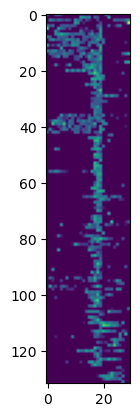

In [8]:
sess = stx.utilities_ES.load_vr_day(mouse,0)
fig,ax = plt.subplots()
ax.imshow(sess.trial_matrices['licks'])

In [15]:
sparse_sessions(3)

TypeError: 'dict' object is not callable

In [25]:
d = sparse_sessions;

for mouse, sess_list in d.items():
    if mouse in ['SparseKO_02','SparseKO_03','SparseKO_05','SparseKO_06','SparseKO_08','SparseKO_09','SparseKO_10','SparseKO_13']:
        continue
        
    else:
        print(mouse)
        for f in sess_list:
            if isinstance(f,dict):
                f_ = update_sess_dict(mouse,f)
                print(mouse, f_)
                _ = run_and_save(f_)
            elif isinstance(f, tuple) or isinstance(f, list):
                comb_frames = 0
                for _f in f:
                    
                    f_ = update_sess_dict(mouse,_f)
                    print(mouse, f_)
                    comb_frames = run_and_save(f_,comb_frames=comb_frames)

SparseKO_11
SparseKO_11 {'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 23, 'novel_arm': 1, 'exp_day': 1, 'mouse': 'SparseKO_11', 'vr_filename': 'Z:/giocomo/esay/Stx3/VRData\\SparseKO_11\\29_05_2025\\YMaze_LNovel_1.sqlite', 'scan_number': 23, 'prompt_for_keys': False, 'VR_only': True, 'scanner': 'NLW'}
Fixing teleports
1
2
3
4
5
0
0
0
0
SparseKO_11 {'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': 1, 'exp_day': 2, 'mouse': 'SparseKO_11', 'vr_filename': 'Z:/giocomo/esay/Stx3/VRData\\SparseKO_11\\30_05_2025\\YMaze_LNovel_1.sqlite', 'scan_number': 12, 'prompt_for_keys': False, 'VR_only': True, 'scanner': 'NLW'}
Fixing teleports
1
2
3
4
5
0
0
0
0
SparseKO_11 {'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'exp_day': 3, 'mouse': 'SparseKO_11', 'vr_filename': 'Z:/giocomo/esay/Stx3/VRData\\SparseKO_11\\31_05_2025\\YMaze_LNovel_1.sqlite', 'scan_number': 9, 'prompt_for_keys': False, 'VR_only': Tr

DatabaseError: database disk image is malformed

In [46]:
for d in (ko_sessions, ctrl_sessions):
    
    for mouse, sess_list in d.items():
        print(mouse)
        for f in sess_list:
            if isinstance(f,dict):
                f_ = update_sess_dict(mouse,f)
                print(mouse, f_)
                _ = run_and_save(f_)
            elif isinstance(f, tuple) or isinstance(f, list):
                comb_frames = 0
                for _f in f:
                    
                    f_ = update_sess_dict(mouse,_f)
                    print(mouse, f_)
                    comb_frames = run_and_save(f_,comb_frames=comb_frames)


AttributeError: 'str' object has no attribute 'items'

In [65]:
basedir = "C:/Users/esay/data/Stx3/YMaze_VR_Pkls"

mouse = 'SparseKO_02'
f_dict = sparse_sessions[mouse]
print(f_dict)
f = f_dict[1]

file = os.path.join(basedir, mouse, f['date'], "%s_%d.pkl" % (f['scene'], f['session']))
sess = stx.session.YMazeSession.from_file(file)

({'date': '16_11_2024', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 14, 'novel_arm': -1, 'exp_day': 1, 'mouse': 'SparseKO_02', 'vr_filename': 'Z:/giocomo/esay/Stx3/VRData\\SparseKO_02\\16_11_2024\\YMaze_LNovel_4.sqlite', 'scan_number': 14, 'prompt_for_keys': False, 'VR_only': True, 'scanner': 'NLW'}, {'date': '17_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 25, 'novel_arm': -1, 'exp_day': 2, 'mouse': 'SparseKO_02', 'vr_filename': 'Z:/giocomo/esay/Stx3/VRData\\SparseKO_02\\17_11_2024\\YMaze_LNovel_1.sqlite', 'scan_number': 25, 'prompt_for_keys': False, 'VR_only': True, 'scanner': 'NLW'}, {'date': '18_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 18, 'novel_arm': -1, 'exp_day': 3, 'mouse': 'SparseKO_02', 'vr_filename': 'Z:/giocomo/esay/Stx3/VRData\\SparseKO_02\\18_11_2024\\YMaze_LNovel_1.sqlite', 'scan_number': 18, 'prompt_for_keys': False, 'VR_only': True, 'scanner': 'NLW'}, {'date': '19_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -

In [66]:
sess.trial_matrices.keys()

dict_keys(['speed_raw', 'bin_edges', 'bin_centers', 'speed', 'licks_rate', 'licks', 'nonconsum_licks', 'licks_sum'])

In [67]:
sess.trial_info['LR']

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1., -1.,  1.,  1.,
        1., -1., -1.,  1., -1., -1.,  1.,  1.,  1., -1., -1., -1., -1.,
       -1., -1.])

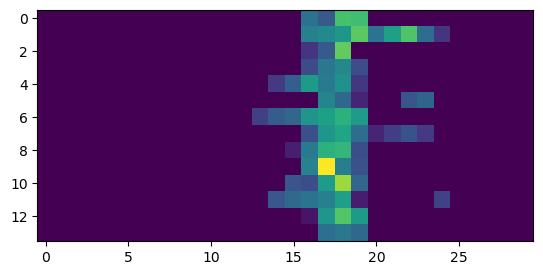

In [68]:
fig, ax = plt.subplots()
ax.imshow(sess.trial_matrices['licks'][sess.trial_info['LR']==-1])